In [1]:
import pandas as pd

In [2]:
from dbscan1d.core import DBSCAN1D

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools 
import scipy 
import numpy as np
from scipy.spatial import distance
import warnings
from sklearn.metrics import mean_squared_error
from dbscan1d.core import DBSCAN1D
from prediction_process.Wishart1 import Wishart
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

## Lorenz timeseries definition:

In [6]:
df = pd.read_fwf('datasets/lorenz.txt')
x_train = np.float32(np.array(df.iloc[:,0])[3000:13000])
y_true = np.float32(np.array(df.iloc[:,0])[13000:15500])

## Bitcoin data 10 minute timeframe definition:

Taken from: https://www.kaggle.com/aakashverma8900/bitcoin-price-usd/version/1

In [7]:
dfr = pd.read_csv('datasets/bitcoin.csv', usecols=['Close Time', 'Close'], parse_dates=['Close'])
dfr.rename(columns={"Close Time": 'close_time'}, inplace=True)
dfr.close_time = pd.to_datetime(dfr.close_time, unit='ms')
dfr.close_time = dfr.close_time.dt.round(freq='S')
dfr = dfr.set_index('close_time')
dfr.Close = dfr.Close.astype('float')
dfr = dfr[::10]
bitcoin_train = dfr.iloc[:10000].values.reshape(1,-1)[0]
#bitcoin_test = dfr.iloc[10000:].values.reshape(1,-1)[0]

## Energy consuption timeseries definition:

Taken from: https://www.kaggle.com/robikscube/hourly-energy-consumption?select=AEP_hourly.csv

In [8]:
el = pd.read_csv('datasets/PJM_Load_hourly.csv', parse_dates=True)
el.Datetime = pd.to_datetime(el.Datetime)
el.set_index('Datetime', inplace=True)
el = el.values.reshape(1, -1)[0]

el_train = el[:20000]
el_test = el[20000:25000]

# normalize train and test datasets
el_train = ((el_train - el_train.min()) / (el_train.max() - el_train.min()))
el_test = ((el_test - el_test.min()) / (el_test.max() - el_test.min()))

I've looked at several sets and found electricity consumption series from https://www.kaggle.com/robikscube/hourly-energy-consumption?select=AEP_hourly.csv to be rather more feasible to predict compared to some other sets, according to the entropy-complexity plane below

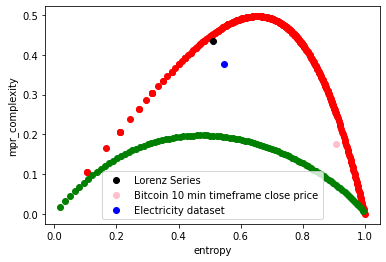

# Pattern and Sample/Motif sets:

In [9]:
pattern_set = [[i1, i2, i3] for i1 in np.arange(1, 11, 1)
               for i2 in np.arange(1, 11, 1)
               for i3 in np.arange(1, 11, 1)]

In [10]:
def get_motifs(pattern_set, data, do_clustering=False, r=11, mu=0.2, beta=1, le=3):

        def cluster_motifs(samples, r, mu):
            clusters = [Wishart(r, mu).fit(i) for i in tqdm(samples)]
            motifs = []
            for n, samp in enumerate(samples):
                motifs.append([])
                for i in range(max(clusters[n]) + 1):
                    motifs[-1].append(np.mean(samp[np.where(clusters[n]==i)], axis=0))
                motifs[-1] = np.array(motifs[-1])

            return motifs

        def get_sample_for_a_pattern(a, le, pat=None):
            if pat == None:
                pat = np.int_(np.ones(le))
            b = np.int_(np.append([0], np.cumsum(pat)))    
            l = []
            for i in range(a.shape[0] - np.sum(pat)): 
                l.append(a[b].reshape(1, -1))
                b = b + 1
      
            return np.concatenate(l, axis=0)

        warnings.filterwarnings("ignore")
        s_s_len = len(pattern_set)

        if beta == 1:
            samples_set = np.array([get_sample_for_a_pattern(data, le, pat = pattern) for pattern in pattern_set])
        elif beta < 1:
            chosen_pats_samples = np.random.choice(np.arange(s_s_len), size=int(s_s_len*beta), replace=False)
            samples_set = np.array([get_sample_for_a_pattern(data, le, pat = pattern) for pattern in np.array(pattern_set)[chosen_pats_samples]])
        #print(cluster_motifs)
        if do_clustering:
            samples_set = cluster_motifs(samples_set, r, mu)

        return samples_set

In [11]:
samples_set_lorenz = get_motifs(pattern_set, x_train)

In [12]:
motifs_set_lorenz = get_motifs(pattern_set, x_train, do_clustering=True)

100%|██████████████████████████████████████| 1000/1000 [05:33<00:00,  3.00it/s]


## Main prediction Class

In [13]:
class TrajectoryPrediction:
    def __init__(self, pattern_set, x, samples_set, y_true, eps=0.005, sigma=0.01, tresh_size1=0.04, tresh_diff=0.2, eps_cl=0.01, min_samples_cl=5):
        # remove
        self.pattern_set = pattern_set
        self.samples_set = samples_set
        self.x = x
        self.tresh_diff = tresh_diff
        self.eps = eps
        self.sigma = sigma
        self.motifs = None
        # the point is deemed unpredictable if the largest cluster comprizes < 4% of all prediction points
        self.tresh_size1 = tresh_size1
        self.eps_cl = eps_cl
        self.min_samples_cl = min_samples_cl
        self.y = self.x.copy()
        self.y_true = y_true

    def Possible_predictions(self, pattern, x, motifs):
        def C(pattern, x):
            c_ = len(x) - np.cumsum(pattern[::-1])
            return x[c_][::-1]

        C_ = C(pattern, x).tolist()
        C_ = [np.float32(i) if i != 'N' else 'N' for i in C_]
        TrCa = motifs[:,:-1]
        if 'N' in C_:

            return []
        else :
            d = distance.cdist(TrCa, [C_], 'euclidean')
            closed_mot_index = np.where(d < self.eps)[0]
            Possible_predictions_ = motifs[closed_mot_index, -1]

            return Possible_predictions_


    def get_possible_prediction_values(self, y):

        Qlist = np.array([self.Possible_predictions(self.pattern_set[i], y, self.samples_set[i]) for i in  range(len(self.pattern_set))])
        Q = np.hstack(Qlist)
        if len(Q) == 0:
            return 'N'
        else:
            return Q


    def predict_one_trajpoint_dbscan(self, y, rand_pert, many):
        Q = self.get_possible_prediction_values(y)
        if len(Q) == 0:
            return 'N'
        elif Q == 'N':
            return 'N'
        Qreshape = Q.reshape(len(Q),1)
        c = DBSCAN1D(eps=self.eps_cl, min_samples=self.min_samples_cl)
        l = c.fit_predict(Qreshape)
        count_cl = np.array(np.unique(l, return_counts = True)).T

        count_cl_without_noize = count_cl[~np.isin(count_cl[:,0],[-1])]
        if count_cl_without_noize.shape[0] == 0:

            return 'N'
        
        elif many:
            max_cl_n = count_cl_without_noize[np.argsort(count_cl_without_noize[:, 1]), :]
            return np.mean(Q[np.where(1 == max_cl_n[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
        
        else:
            count_cl_without_noize_sorted = count_cl_without_noize[np.argsort(count_cl_without_noize[:,1]), :]
            ## size1 - size of the largest cluster
            size1 = count_cl_without_noize_sorted[-1, 1] / Q.size 
            if count_cl_without_noize_sorted.shape[0] > 1:
                ## size2 - size of the second-largest cluster
                size2 = count_cl_without_noize_sorted[-2, 1] / Q.size 
            else:
                size2 = 0
            if size2 != 0:
                if (size1 < self.tresh_size1) | (size1 - size2 < self.tresh_diff):
                    return 'N'
                else:
                    if rand_pert:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])])
            else:
                if size1 < self.tresh_size1:
                    return 'N'
                else:
                    if rand_pert:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
                    else:
                        return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])])
                        
                        
#     def predict_one_trajpoint_dbsc_custom(self, y, rand_pert, many):
#         Q = self.get_possible_prediction_values(y)
#         if len(Q) == 0:
#             return 'N'
#         elif Q == 'N':
#             return 'N'
#         Qreshape = Q.reshape(len(Q),1)
#         c = DBSCAN1D(eps=self.eps_cl, min_samples=self.min_samples_cl)
#         l = c.fit_predict(Qreshape)
#         count_cl = np.array(np.unique(l, return_counts = True)).T

#         count_cl_without_noize = count_cl[~np.isin(count_cl[:,0],[-1])]
#         if count_cl_without_noize.shape[0] == 0:

#             return 'N'
        
#         elif many:
#             max_cl_n = count_cl_without_noize[np.argsort(count_cl_without_noize[:, 1]), :]
#             return np.mean(Q[np.where(1 == max_cl_n[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
        
#         else:
#             count_cl_without_noize_sorted = count_cl_without_noize[np.argsort(count_cl_without_noize[:,1]), :]
#             ## size1 - size of the largest cluster
#             size1 = count_cl_without_noize_sorted[-1, 1] / Q.size 
#             if count_cl_without_noize_sorted.shape[0] > 1:
#                 ## size2 - size of the second-largest cluster
#                 size2 = count_cl_without_noize_sorted[-2, 1] / Q.size 
#             else:
#                 size2 = 0
#             if size2 != 0:
#                 if (size1 < self.tresh_size1) | (size1 - size2 < self.tresh_diff):
#                     return 'N'
#                 else:
#                     if rand_pert:
#                         return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
#                     else:
#                         return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
#             else:
#                 if size1 < self.tresh_size1:
#                     return 'N'
#                 else:
#                     if rand_pert:
#                         return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]
#                     else:
#                         return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, self.sigma, 1)[0]

    def My_pull(self, T, rand, many, y=None):
        if y is None:
            y = self.x.copy()
        
        pred = []
        for i in range(T):
            pred.append(self.predict_one_trajpoint_dbscan(y, rand, many))
            y = np.append(y, pred[-1])
        return pred

    
    def pull_ppvs(self, T, step, samples):
        y = self.x.copy()
        all_preds = []
        for loop in tqdm(range(samples)):
            
            pred = []
            for i in range(T):
                pred.append(self.get_possible_prediction_values(y))
                y = np.append(y, pred[-1])
            y = np.append(self.x, self.y_true[:(loop+1)*step])
            all_preds.append(pred)
        return all_preds
            
        
    def predict(self, h, sample_size, noise: bool, step=1, s=1):
        self.preds = []
        
        if s > 1:
            many = True
        else:
            many = False
            
        for i in range(s):
            self.preds.append([self.My_pull(h, noise, many, np.append(self.x, self.y_true[:step*j])) for j in tqdm(range(sample_size))])
        return self.preds

## Params Plots

In [14]:
def parameters_function1(p, tr, h):
    ###########
    ### k goes from 1 to 10
    def get_h_p(p,k):
        v = []
        for i in range(len(p)):
            try:
                v.append(p[i][k - 1])
            except IndexError:
                pass
        return v
    #############
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #############
    pred_all = [list(zip(get_h_p(tr,i),get_h_p(p,i))) for i in range(1, h + 1)]
    rmse_dem = []
    mape_dem = []
    N_score = []
    for i in range(len(pred_all)):
        metric = []
        N_ = 0
        for y in pred_all[i]:
            if 'N' in y:
                N_ += 1
            else:
                metric.append([y[0],y[1]])
        N_ = N_ / len(pred_all[i])
        metric = np.array(metric)
        if metric.size > 0:
            if len(metric) > 1:
                score_rmse = mean_squared_error(np.float_(metric[:,0]), np.float_(metric[:,1]), squared=False)
                score_mape = mean_absolute_percentage_error(np.float_(metric[:,0]), np.float_(metric[:,1]))
                rmse_dem.append(score_rmse)
                mape_dem.append(score_mape)
                N_score.append(N_)
        else:
            rmse_dem.append(np.nan)
            mape_dem.append(np.nan)
            N_score.append(1)
     
    return rmse_dem, mape_dem, N_score, pred_all

In [25]:
def plot_metrics(params, name):
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[0])
    plt.title(f'{name} \n' + 'rmse sum' +' '+ str(f'{sum(params[0]):.4f}'))
    plt.show()
    print(sum(params[0]))
    
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[1])
    plt.title(f'{name} \n' + 'mape sum' +' '+ str(f'{sum(params[1]):.4f}'))
    plt.show()
    print(sum(params[1]))
    
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='both', axis='both', alpha=0.5)
    plt.plot(params[2])
    plt.title(f'{name} \n' + 'N% sum' +' '+  str(f'{sum(params[2]):.4f}'))
    plt.show()
    print(sum(params[2]))

In [16]:
def plot_predictions(preds, true, title, size):
    f_preds = np.ravel(preds)
    plt.figure(figsize=(20,10))
    plt.plot(range(size), [np.float64(i) if i !='N' else np.nan for i in f_preds], color='r', label='predicted_values')
    plt.plot(true[:size], alpha=0.7, label='true_values')
    plt.legend(fontsize=12)
    plt.title(title, fontsize=20)

## One trajectory no clustering for lorenz series with h=25

In [17]:
h1 = 25
lorenz_pred_samp = TrajectoryPrediction(pattern_set, x_train, samples_set_lorenz, y_true=y_true)
pred3 = lorenz_pred_samp.predict(h1, sample_size=40, noise=False, step=h1)

100%|██████████████████████████████████████████| 40/40 [07:36<00:00, 11.42s/it]


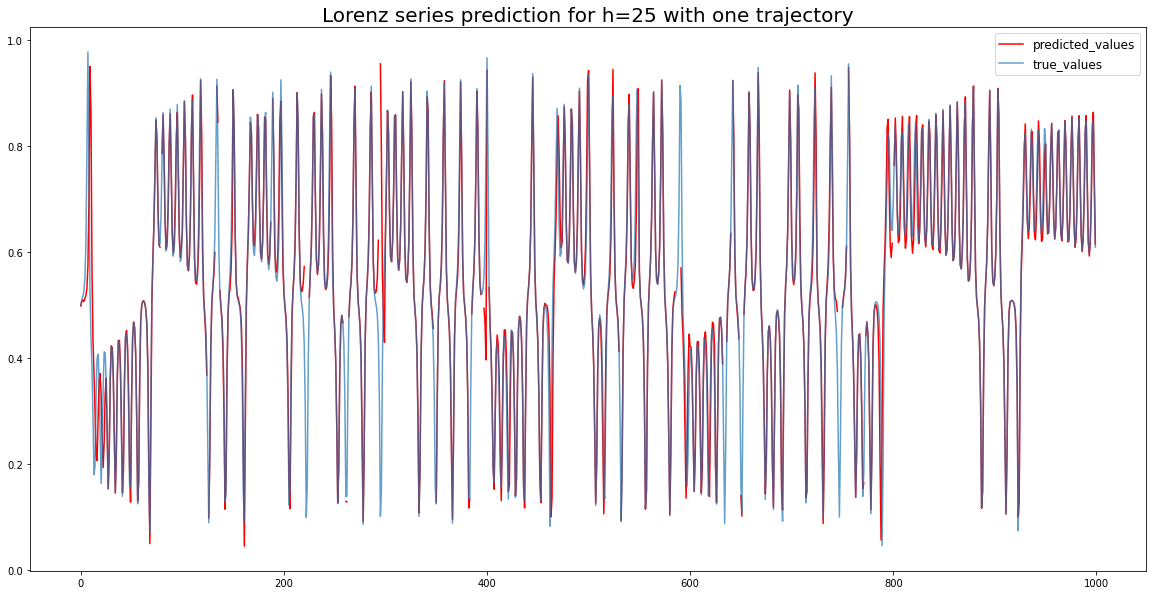

In [18]:
plot_predictions(pred3, y_true, 'Lorenz series prediction for h=25 with one trajectory', 1000)

The results seem legit. So, I'd test the algorithm for h=100

## One trajectory no clustering for lorenz series with h=100

In [19]:
lorenz_pred_samples1 = TrajectoryPrediction(pattern_set, x_train, samples_set_lorenz, y_true=y_true)
#p4 = lorenz_pred_samples1.predict(100, sample_size=1000)

In [20]:
lorenz_pred_samples = TrajectoryPrediction(pattern_set, x_train, samples_set_lorenz, y_true=y_true)
p4 = lorenz_pred_samples1.predict(100, sample_size=1000, noise=False, step=1)

100%|███████████████████████████████████| 1000/1000 [10:31:12<00:00, 37.87s/it]


In [21]:
tr3 = [y_true[i: i + 100].tolist() for i in range(1000)]

In [23]:
params4 = parameters_function1(p4[0], tr3, 100)

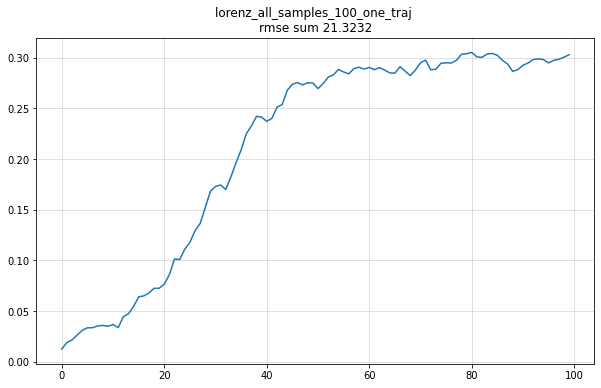

21.323160180452675


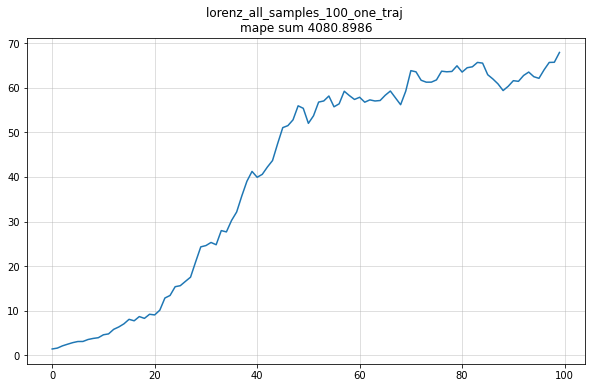

4080.8986099655426


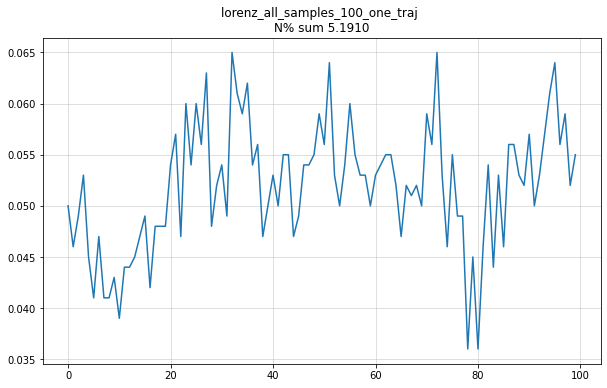

5.191


In [26]:
plot_metrics(params4, 'lorenz_all_samples_100_one_traj')

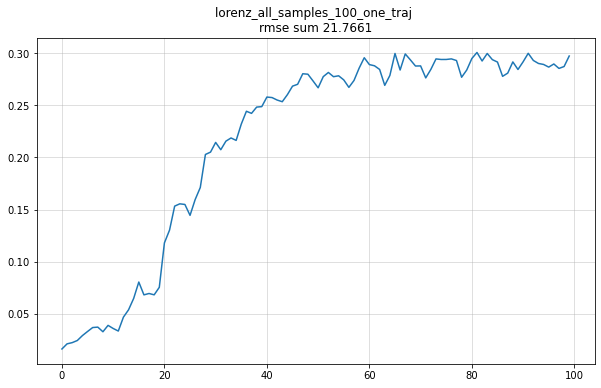

21.766071483735132


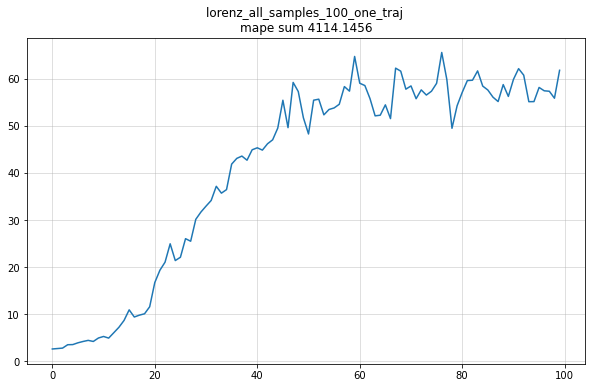

4114.145625022421


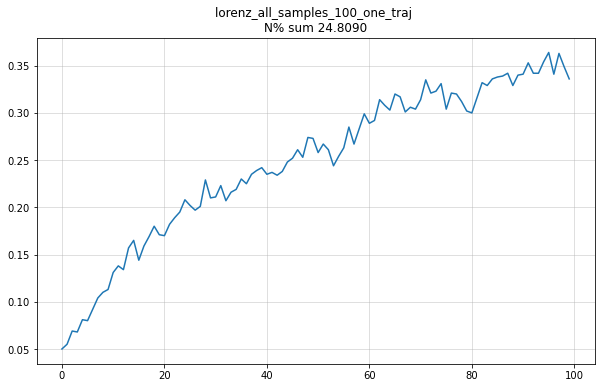

24.808999999999994


In [433]:
plot_metrics(params4, 'lorenz_all_samples_100_one_traj')

Let's visualize the predictions:

100%|██████████| 10/10 [03:49<00:00, 22.98s/it]


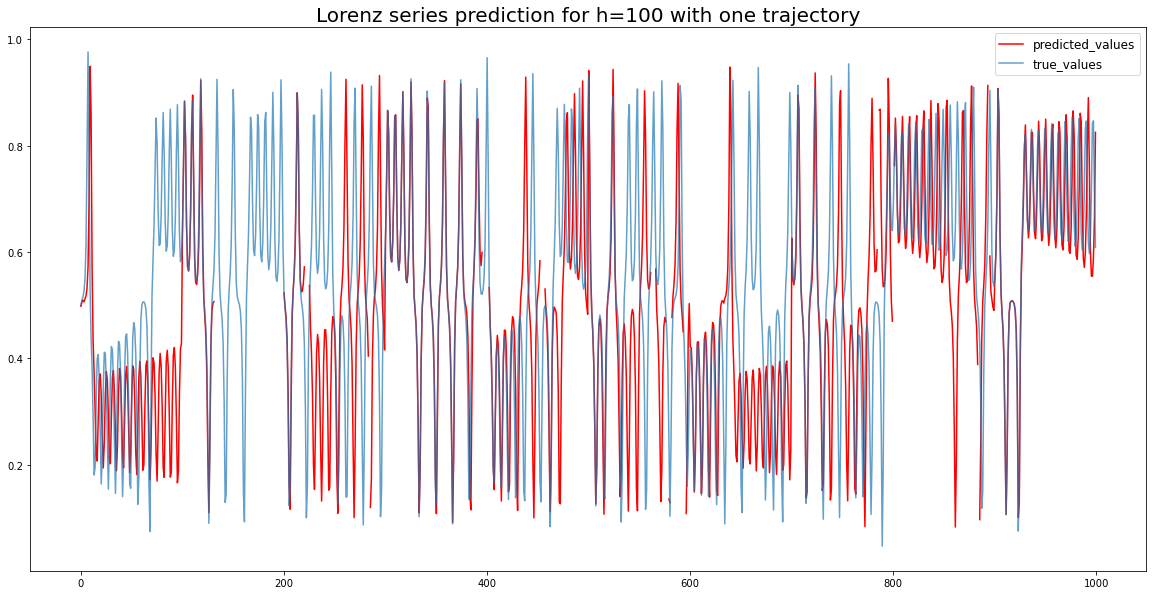

In [447]:
pred_vis = lorenz_pred_samp.predict(100, sample_size=10, noise=False, step=100)
plot_predictions(pred_vis, y_true, 'Lorenz series prediction for h=100 with one trajectory', 1000)

In [ ]:
f_preds3 = np.ravel(preds3)
plt.figure(figsize=(20,10))
plt.plot(range(1000), [np.float64(i) if i !='N' else np.nan for i in f_preds3], color='r')
plt.plot(y_true[:1000], alpha=0.7)

The algorithm seems to be predicting too hard from the pattern_samples. Let's check the predictions on the clustered version:

## Clustered version Lorenz h=25 one traj

In [149]:
lorenz_pred_clustered = TrajectoryPrediction(pattern_set, x_train, motifs_set_lorenz, y_true=y_true)

100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


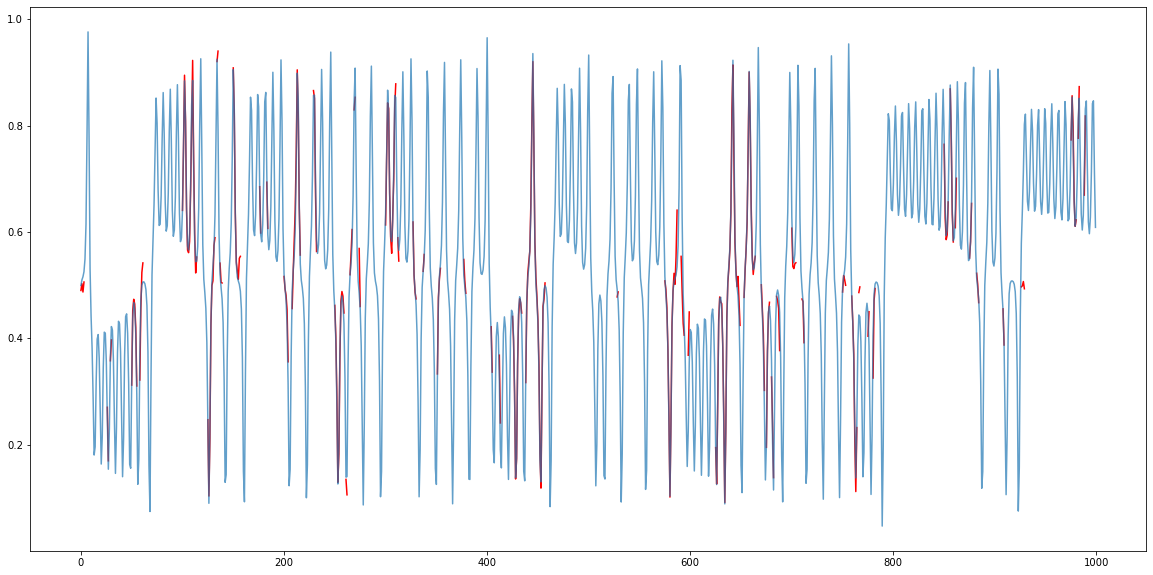

In [150]:
preds3 = lorenz_pred_clustered.predict(25, sample_size=40, noise=False, step=25)
f_preds3 = np.ravel(preds3)
plt.figure(figsize=(20,10))
plt.plot(range(1000), [np.float64(i) if i !='N' else np.nan for i in f_preds3], color='r')
plt.plot(y_true[:1000], alpha=0.7)

## Clustered version Lorenz h=100 one traj

In [449]:
lorenz_pred_motifs = TrajectoryPrediction(pattern_set, x_train, motifs_set_lorenz, y_true=y_true)

In [363]:
lorenz_pred_mot = TrajectoryPrediction(pattern_set, x_train, motifs_set_lorenz, y_true=y_true)
pp = lorenz_pred_mot.predict(100, sample_size=10, step=100, noise=True)

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


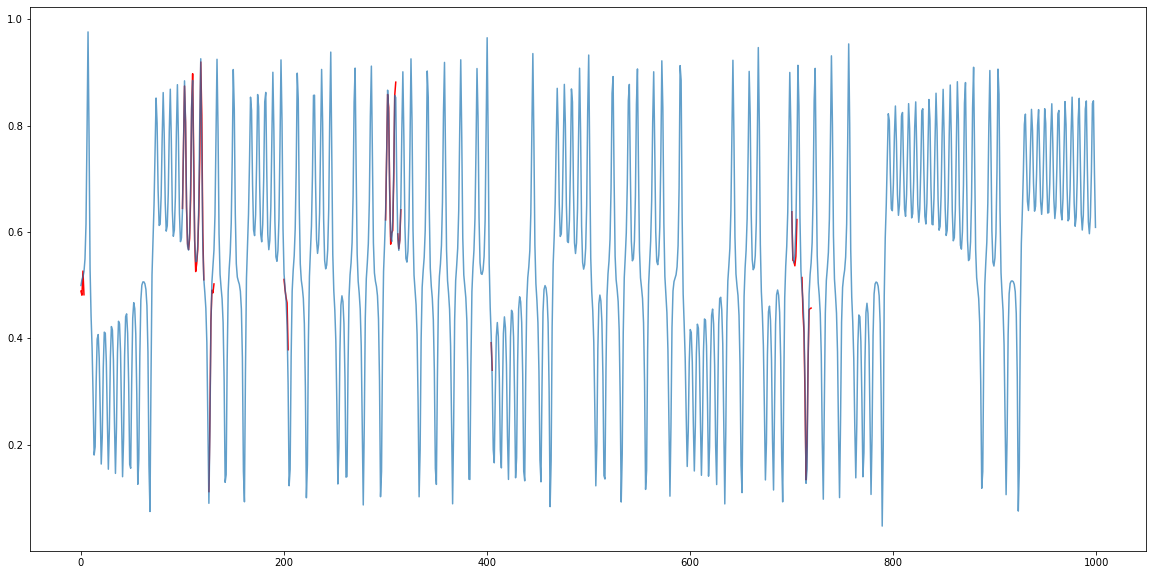

In [364]:

lorenz_one_traj = np.ravel(pp[0])
plt.figure(figsize=(20,10))
plt.plot(range(1000), [np.float64(i) if i !='N' else np.nan for i in lorenz_one_traj], color='r')
plt.plot(y_true[:1000], alpha=0.7)

In [365]:
pre = lorenz_pred_mot.predict(100, sample_size=1000, noise=True)

100%|██████████| 1000/1000 [36:11<00:00,  2.17s/it]


In [460]:
params_lorenz_mot1 = parameters_function1(pre[0], tr3, 100)

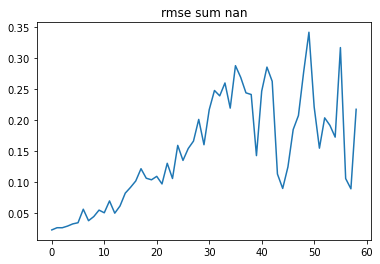

nan


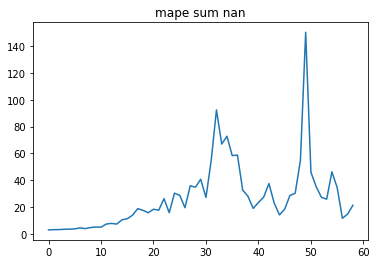

nan


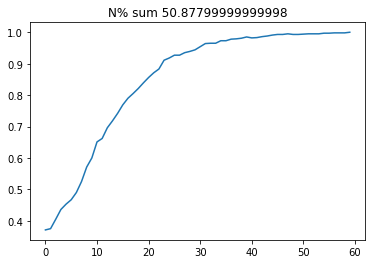

50.87799999999998


In [461]:
plt.plot(params_lorenz_mot1[0])
plt.title('rmse sum' +' '+ str(sum(params_lorenz_mot1[0])))
plt.show()
print(sum(params_lorenz_mot1[0]))

plt.plot(params_lorenz_mot1[1])
plt.title('mape sum' +' '+ str(sum(params_lorenz_mot1[1])))
plt.show()
print(sum(params_lorenz_mot1[1]))

plt.plot(params_lorenz_mot1[2])
plt.title('N% sum' +' '+ str(sum(params_lorenz_mot1[2])))
plt.show()
print(sum(params_lorenz_mot1[2]))

# Electricity consumption data-set

In [186]:
samples_set_electricity = get_motifs(pattern_set, el_train)

In [187]:
motifs_set_electricity = get_motifs(pattern_set, el_train, do_clustering=True)

100%|██████████| 1000/1000 [10:52<00:00,  1.53it/s]


In [213]:
electricity_pred_samples = TrajectoryPrediction(pattern_set, el_train, samples_set_electricity, y_true=el_test)

In [214]:
el_pred1 = electricity_pred_samples.predict(100, 10, step=100)

100%|██████████| 10/10 [02:30<00:00, 15.08s/it]


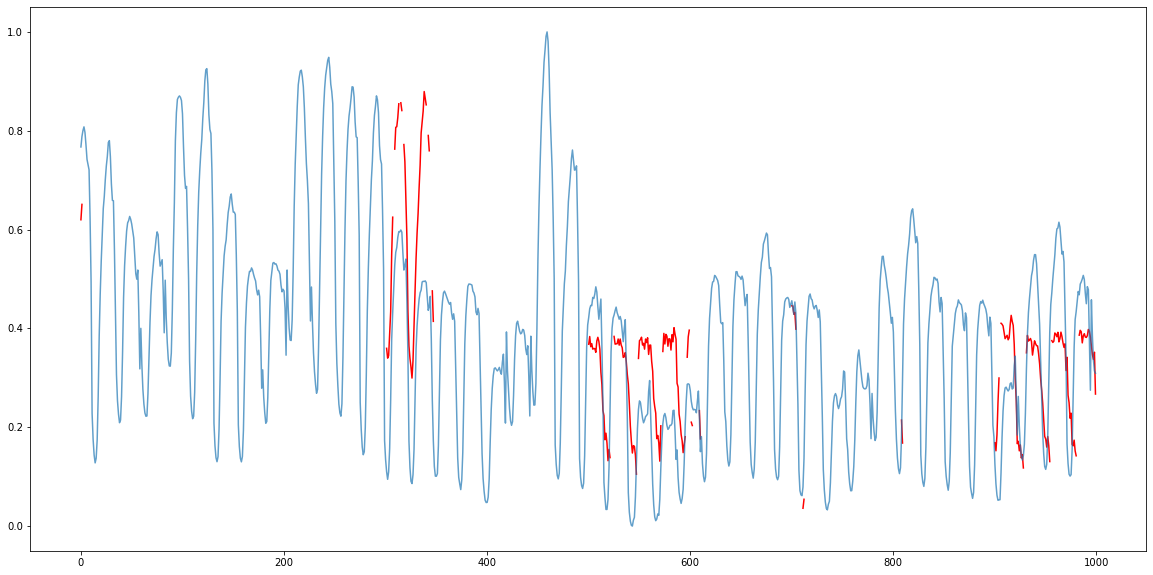

In [215]:
el_preds1 = np.ravel(el_pred1)
plt.figure(figsize=(20,10))
plt.plot(range(1000), [np.float64(i) if i !='N' else np.nan for i in el_preds1], color='r')
plt.plot(el_test[:1000], alpha=0.7)

The above plot doesn't look too promising

In [219]:
electricity_pred_motifs.predict(100, 10, step=100)

100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


[[[0.6201342188874591,
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N'],
  ['N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',
   'N',


In [220]:
pred_el_ = _

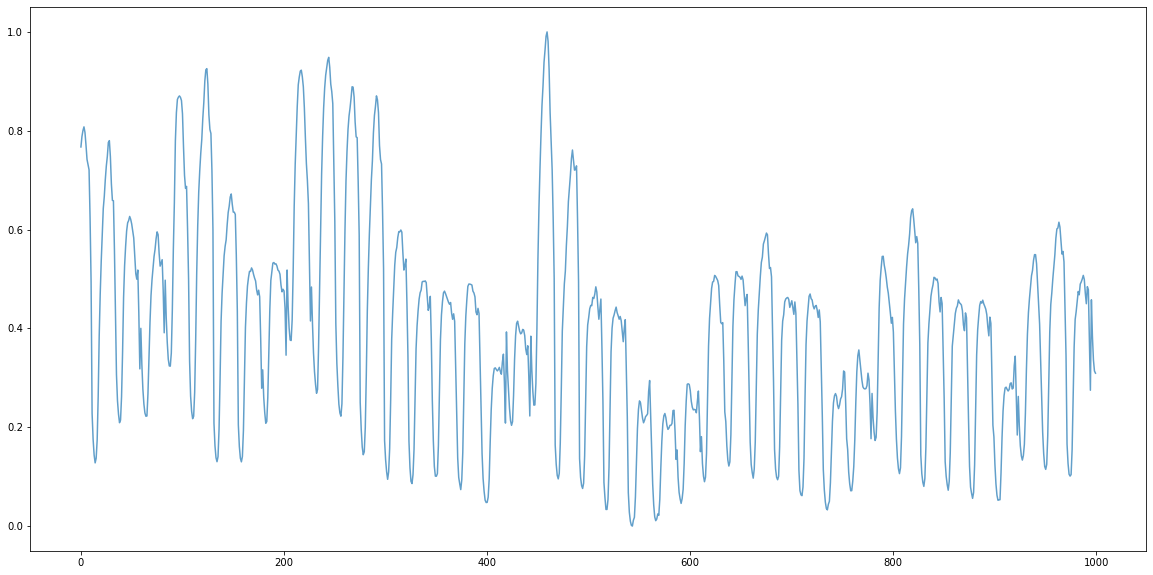

In [221]:
el_preds2 = np.ravel(pred_el_)
plt.figure(figsize=(20,10))
plt.plot(range(1000), [np.float64(i) if i !='N' else np.nan for i in el_preds2], color='r')
plt.plot(el_test[:1000], alpha=0.7)

Yep, clustering doesn't help either, from the first glance

In [224]:
el_pred2 = electricity_pred_samples.predict(12, 100, step=12)

100%|██████████| 100/100 [07:38<00:00,  4.58s/it]


In [218]:
electricity_pred_motifs = TrajectoryPrediction11(pattern_set, el_train, motifs_set_electricity, y_true=el_test)

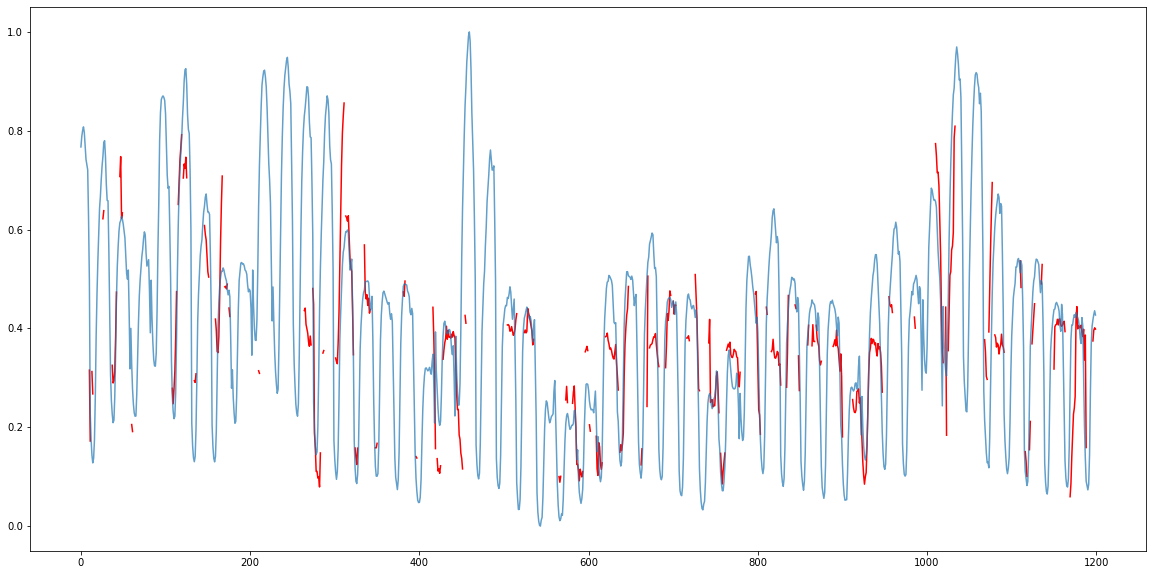

In [225]:
el_preds2 = np.ravel(el_pred2)
plt.figure(figsize=(20,10))
plt.plot(range(1200), [np.float64(i) if i !='N' else np.nan for i in el_preds2], color='r')
plt.plot(el_test[:1200], alpha=0.7)

Although on the smaller prediction horizon it looks better. I will try explore more depth by employing more patterns to look for matches. And create more clusters with r parameter to preserve more diversity

In [226]:
pattern_set_extended = [[i1, i2, i3] for i1 in np.arange(1, 16, 1)
               for i2 in np.arange(1, 16, 1)
               for i3 in np.arange(1, 16, 1)]

In [228]:
motifs_set_el_extended = get_motifs(pattern_set_extended, el_train, do_clustering=True, r=8)

100%|██████████| 3375/3375 [34:26<00:00,  1.63it/s]


In [230]:
electricity_pred_motifs_ext = TrajectoryPrediction(pattern_set_extended, el_train, motifs_set_el_extended, y_true=el_test)

In [235]:
p5 = electricity_pred_motifs_ext.predict(100, sample_size=1000, step=1)

100%|██████████| 1000/1000 [2:02:13<00:00,  7.33s/it] 


In [462]:
electricity_pred_motifs_ext1 = TrajectoryPrediction(pattern_set_extended, el_train, motifs_set_el_extended, y_true=el_test)

In [392]:
electro = TrajectoryPrediction(pattern_set_extended, el_train, motifs_set_el_extended, y_true=el_test, eps=0.005)

In [393]:
electro_pred1 = electro.predict(100, sample_size=20, step=100, noise=False)

100%|██████████| 20/20 [03:35<00:00, 10.76s/it]


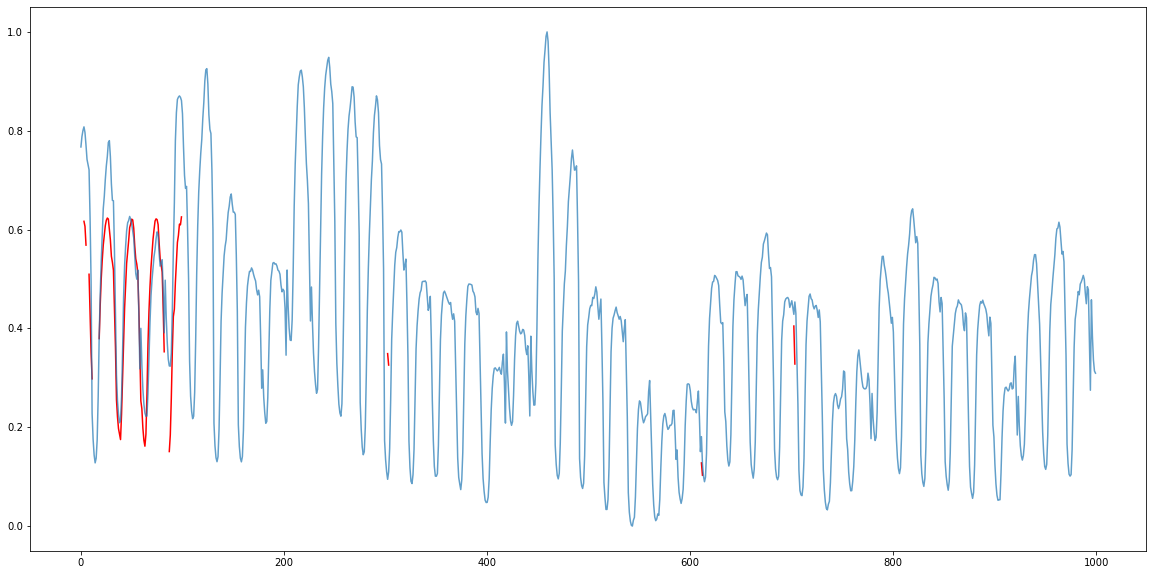

In [468]:
e = np.ravel(electro_pred1[0])[:1000]
plt.figure(figsize=(20,10))
plt.plot(range(1000), [np.float64(i) if i !='N' else np.nan for i in e], color='r')
plt.plot(el_test[:1000], alpha=0.7)

Extended motifs set seems to be doing better

In [464]:
p55 = electricity_pred_motifs_ext1.predict(100, sample_size=1000, noise=False, step=1)

100%|██████████| 1000/1000 [2:31:32<00:00,  9.09s/it] 


In [399]:
trr = [el_test[i: i + 100].tolist() for i in range(len(el_test[:1000]))]

In [469]:
params_no_noise_single1 = parameters_function1(p55[0], trr, 100)

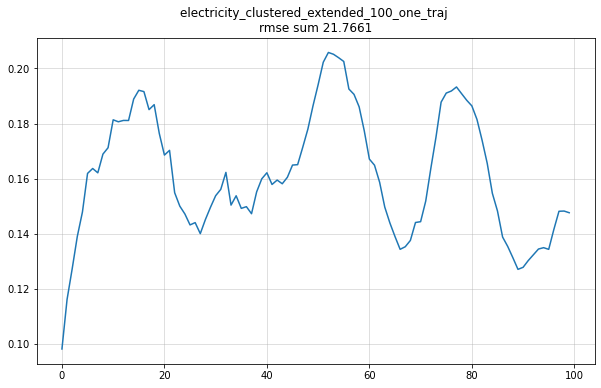

16.14880964377224


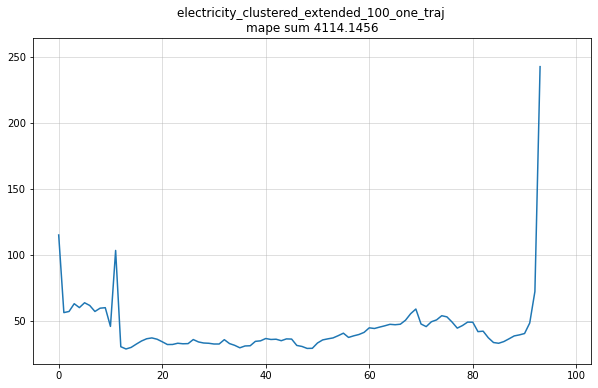

inf


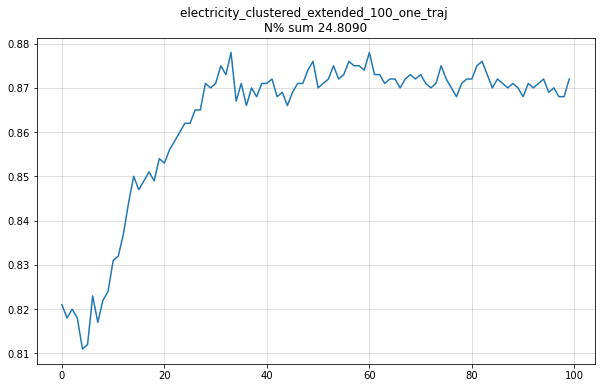

86.25999999999999


In [470]:
plot_metrics(params_no_noise_single1, 'electricity_clustered_extended_100_one_traj')

# Multiple Trajectories with random perturbation

## Algorithm for trajectories clustering

In [113]:
def MaxClusterSet(data_, eps_, minsam):
    n = data_.size
    data = data_[data_ != 'N']
    if data.size != 0:
        labs = DBSCAN1D(eps=eps_, min_samples=minsam).fit_predict(data)
        data_not_noize = data[np.where(labs != -1)]
        labs_not_noize = labs[np.where(labs != -1)]
        w, count =  np.unique(labs_not_noize, return_counts=True)
        if len(count) != 0:
            w_max = w[np.where(count == np.max(count))]
            if w_max.size == 1:
                w_max_ind = np.where(labs_not_noize == w_max)
                max_clust = data_not_noize[w_max_ind]
                return max_clust,  max_clust.size / n, list(data_).count('N') / n
            else:
                return np.array([]), 0, 0
        else: 
            return np.array([]), 0, 0
    else:
        return np.array([]), 0, 0
    
    
def PredictTrajectories(tra_ , tresh, eps_, minsam):
    tra = np.array(tra_, dtype=object).T
    pred_ = []
    for tr in tra:
        max_cl_data, order, n_N = MaxClusterSet(tr, eps_, minsam)
        if (order > tresh) :
            pred_.append(np.mean(max_cl_data))
        else:
            pred_.append('N')
    return pred_

# Electricity multiple traj

In [485]:
electro_many = TrajectoryPrediction(pattern_set, el_train, motifs_set_electricity, y_true=el_test, eps=0.01)

In [486]:
electro_multiple_traj = electro_many.predict(10, 750, noise=True, s=10)

100%|██████████| 750/750 [07:14<00:00,  1.72it/s]


In [500]:
multi_preds_el = [[i[j] for i in electro_multiple_traj] for j in range(len(electro_multiple_traj[0]))]

In [536]:
unified_el = [PredictTrajectories(f, 0.3, 0.06, 2) for f in multi_preds_el]

In [537]:
y_tr_el = [el_test[i: i+10].tolist() for i in range(750)]

In [539]:
unified_el

[[nan, nan, nan, nan, 'N', 'N', 'N', 'N', 'N', 'N'],
 [nan, nan, nan, 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 [nan, nan, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 [nan, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [540]:
# too few samples/trajectories for adequate assessment

# Lorenz multiple traj

Predictions for multiple trajectory lorenz have been computed in a different notebook and I've added the code below.

In [ ]:
# lorenz_motifs_diverse = get_motifs(patern_set, x_train, do_clustering=True, r=8, mu=0.7)
# lorenz_motifs_pred_multiple = TrajectoryPrediction(pattern_set, x_train, lorenz_motifs_diverse, eps=0.01)
# lorenz_h40_s30_cl = lorenz_motifs_pred_multiple.predict(40, 1000, noise=True, s=30)

In [525]:
with open('lorenz_multiple_traj.pickle', 'rb') as f:
    lorenz_h40_s30_cl = pickle.load(f)

In [526]:
multi_preds = [[i[j] for i in lorenz_h40_s30_cl] for j in range(len(lorenz_h40_s30_cl[0]))]

In [527]:
unified = [PredictTrajectories(f, 0.5, 0.008, 8) for f in multi_preds]

In [1]:
# Example for one sample

  6%|▌         | 46/750 [1:18:35<20:02:42, 102.50s/it]


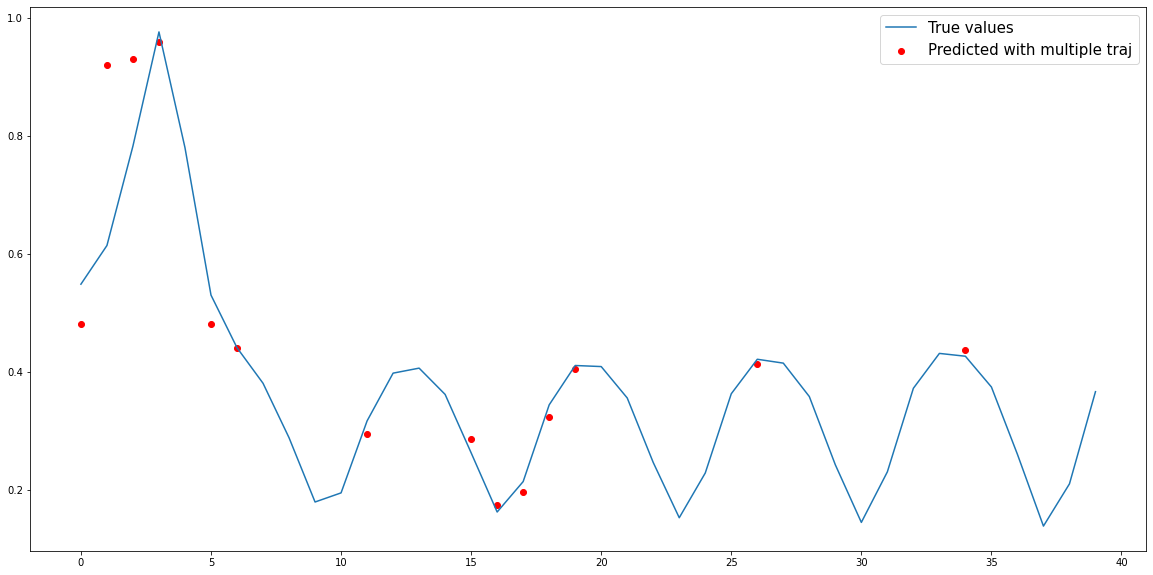

In [531]:
plt.figure(figsize=(20,10))
plt.scatter(np.arange(40), [i if i != 'N' else np.nan for i in unified[4]], color='r', label='Predicted with multiple traj')
plt.plot(np.arange(40), y_true[4:44], label='True values')
plt.legend(fontsize=15)

In [532]:
y_tr = [y_true[i: i+40].tolist() for i in range(1000)]

In [534]:
lorenz_multi_params = parameters_function1(unified, y_tr, 40)

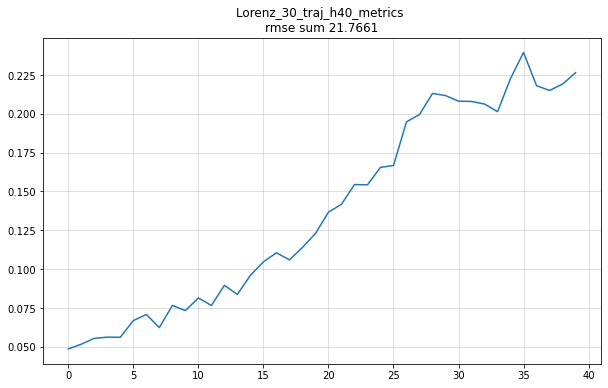

5.507287196690766


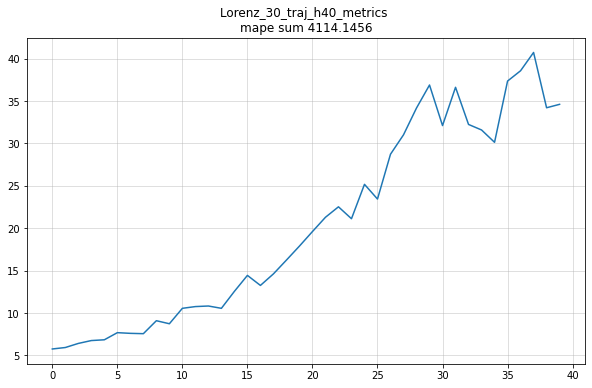

816.192986462568


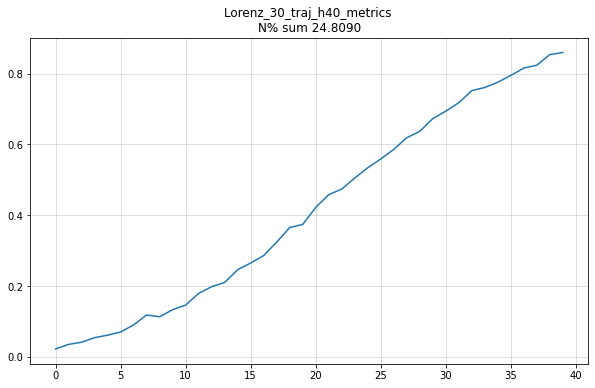

16.647


In [535]:
plot_metrics(lorenz_multi_params, 'Lorenz_30_traj_h40_metrics')

Not enough steps to see the behaviour after reaching peak unpred points

For h = 100 with eps=0.005

In [109]:
h4 = 100
lorenz_pred_default5 = TrajectoryPrediction(pattern_set, x_train, motifs_set_lorenz)
pred5 = lorenz_pred_default5.predict(h4, sample_size=1000, noise=True step=1, s=30)

100%|██████████| 1000/1000 [30:34<00:00,  1.83s/it]


In [337]:
hh = [[i[j] for i in pred5] for j in range(len(pred5[0]))]

In [356]:
unified = [PredictTrajectories(f, 0.25, 0.02, 5) for f in hh]
tr = [y_true[i: i+100].tolist() for i in range(1000)]

In [357]:
motifs_multiple30 = parameters_function1(unified, tr, 100)

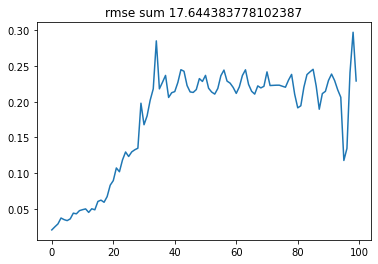

17.644383778102387


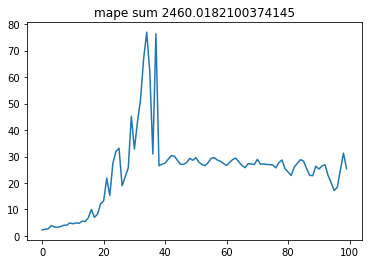

2460.0182100374145


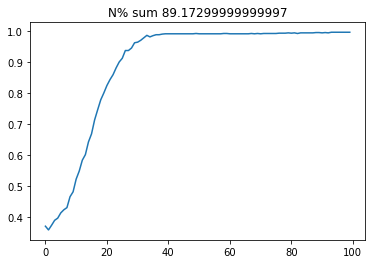

89.17299999999997


In [358]:
plt.plot(motifs_multiple30[0])
plt.title('rmse sum' +' '+ str(sum(motifs_multiple30[0])))
plt.show()
print(sum(motifs_multiple30[0]))

plt.plot(motifs_multiple30[1])
plt.title('mape sum' +' '+ str(sum(motifs_multiple30[1])))
plt.show()
print(sum(motifs_multiple30[1]))

plt.plot(motifs_multiple30[2])
plt.title('N% sum' +' '+ str(sum(motifs_multiple30[2])))
plt.show()
print(sum(motifs_multiple30[2]))